# Implementación de SGD para la función XOR

In [330]:
import numpy as np
import matplotlib.pyplot as plt

## Función sigmoidea

In [331]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

## Función de pérdida

In [332]:
def loss(y, y_pred):
  diff = y - y_pred
  return np.mean(diff**2)

## Función de predicción

In [333]:
def predict(x, w):
  
  # Reordeno vector de parametros como matriz de 3x3, donde cada columna contiene los parámetro de cada neurona
  W = np.reshape(w, (3, 3)).T

  # Calculo z para las neuronas de la capa 1
  z_L1 = x @ W[:, :-1]
  # Calculo la salida para las neuronas de la capa 1 (incluyendo termino independiente)
  a_L1 = np.append(sigmoid(z_L1), np.array([1]))

  # Calculo salida de la neurona de la capa 2
  z_L2 = np.dot(a_L1, W[:, -1]) #Prediccion para la i-esima fila del dataset

  return [z_L2, a_L1, z_L1, W]

In [334]:
y_true=.23434445
x=np.array([2, 5, 1])
w=np.random.rand(9)
fwd = predict(x,w)
print(fwd)

[1.399117503840827, array([0.99830058, 0.83082487, 1.        ]), array([6.37576513, 1.59148455]), array([[0.42435961, 0.53282604, 0.50202957],
       [0.96092629, 0.08806497, 0.31849534],
       [0.72241445, 0.08550763, 0.63332725]])]


## Función para calcular el gradiente de la función de perdida respecto a los parámetros del modelo

In [335]:
def gradient(x, err, pred_vars):
  # Derivada de loss respecto a la y_pred
  dL_dypred = -2*err
  z_L2, a_L1, z_L1, W = pred_vars[0], pred_vars[1], pred_vars[2], pred_vars[3]
  
  # Derivada respecto a los parámetros de la capa L2
  dL_w2b2 = dL_dypred*a_L1

  # Derivada respecto a los parámetros de la capa L1
  dypred_da1 = W[0:2, -1]
  da1_dz1 = sigmoid(z_L1)*(1-sigmoid(z_L1))
  dypred_dz1 = dypred_da1*da1_dz1
  dL_w1b1 = dL_dypred*np.tensordot(x, dypred_dz1, axes=0)

  # Gradiente
  gradJ = np.reshape(dL_w1b1.T, (6,)) #Primero debo trasponer para que la salida sea el apilamiento de las columnas de la matriz
  gradJ = np.append(gradJ, dL_w2b2)
  
  return gradJ

In [336]:
grad1 = gradient(x,y_true-fwd[0],fwd)
print(grad1)

[3.96820078e-03 9.92050196e-03 1.98410039e-03 2.08569306e-01
 5.21423266e-01 1.04284653e-01 2.32558722e+00 1.93544483e+00
 2.32954611e+00]


## Derivada numerica

In [337]:
def NumDiff(y, y_pred0, x, w0):
  nw = len(w0)
  dw = 1e-6
  f0 = loss(y, y_pred0)
  grad = []
  for i in range(nw):
    w = np.copy(w0)
    w[i] = w[i] + dw
    pred = predict(x, w)
    y_pred = pred[0]
    f = loss(y, y_pred)
    df_dw = (f-f0)/dw
    grad.append(df_dw)

  return np.asarray(grad)


In [338]:
grad2 = NumDiff(y_true, fwd[0], x, w)
print(grad2)

[3.96819710e-03 9.92047711e-03 1.98409933e-03 2.08569176e-01
 5.21422453e-01 1.04284621e-01 2.32558822e+00 1.93544552e+00
 2.32954711e+00]


## Comprobación entre derivada numérica y derivada calculada por diferenciacion automática

In [339]:
grad1/grad2

array([1.00000093, 1.00000251, 1.00000054, 1.00000062, 1.00000156,
       1.00000031, 0.99999957, 0.99999964, 0.99999957])

## Algortimo SGD

In [340]:
def sgd(X, y, w, lr, epochs):
  N, d = X.shape
  MSE = []
  for i in range(epochs):
    y_pred = np.empty((N,))
    for j in range(N):
      # Selecciono fila j del dataset
      x_j = X[j,:]
      # Selecciono componente y de la variable target
      y_j = y[j]
      # Paso forward utilizando la fila j
      pred_vars = predict(x_j, w)
      y_pred_j = pred_vars[0]
      y_pred[j] = y_pred_j
      # Calculo del residuo
      err_j = y_j - y_pred_j
      # Paso backpropagation
      gradJ = gradient(x_j, err_j, pred_vars)
      # Derivada numérica
      gradJ2 = NumDiff(y_j, y_pred_j, x_j, w) 
      # Comparacion backprop y derivada numerica
      #print("Derivada computada por backpropagation:", gradJ)
      #print("Derivada computada por diferencias finitas:", gradJ2)
      #print("Relación entre las derivadas:", gradJ/gradJ2)
      # Actualizacion de pesos
      w = w - lr*gradJ
      
    mse = loss(y, y_pred)
    MSE.append(mse)
    print("Epoch:", i, "MSE:", mse)

  return w, MSE

## Main - Minimización utilizando SGD en el problema de ajuste a la función XOR

In [341]:
# Dataset
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

N, d = X.shape

# Agrego columna de unos
X = np.append(X, np.ones((N,1)), axis=1)

# Variable target
y = np.array([0, 1, 1, 0])

# Arquitectura de la ANN
n_layers = 2
neuronas_L1 = 2
neuronas_L2 = 1

# Hiperparámetros del modelo
learningRates = [0.01, 0.1, 1, 5, 10] # Learning rates
epochs = 100 # N° de iteraciones máximas de SGD

# Inicializacion random de los parámetros del modelo
n_param = 9
w0 = np.random.rand(n_param)

# Llamada al algoritmo de Stochastic Gradient Descent
w, MSE = sgd(X, y, w0, 0.001, epochs)

#for lr in learningRates:
   #w, MSE = sgd(X, y, lr, epochs)

Epoch: 0 MSE: 0.24929937614343795
Epoch: 1 MSE: 0.24927003445887674
Epoch: 2 MSE: 0.2492416927782107
Epoch: 3 MSE: 0.24921431643580383
Epoch: 4 MSE: 0.2491878719661473
Epoch: 5 MSE: 0.24916232706231853
Epoch: 6 MSE: 0.24913765053587955
Epoch: 7 MSE: 0.2491138122781627
Epoch: 8 MSE: 0.24909078322289938
Epoch: 9 MSE: 0.24906853531014117
Epoch: 10 MSE: 0.24904704145143103
Epoch: 11 MSE: 0.2490262754961808
Epoch: 12 MSE: 0.24900621219921248
Epoch: 13 MSE: 0.2489868271894233
Epoch: 14 MSE: 0.24896809693953637
Epoch: 15 MSE: 0.24894999873689788
Epoch: 16 MSE: 0.24893251065528574
Epoch: 17 MSE: 0.24891561152769381
Epoch: 18 MSE: 0.24889928092005853
Epoch: 19 MSE: 0.2488834991058954
Epoch: 20 MSE: 0.24886824704181218
Epoch: 21 MSE: 0.248853506343871
Epoch: 22 MSE: 0.2488392592647679
Epoch: 23 MSE: 0.24882548867180249
Epoch: 24 MSE: 0.24881217802560973
Epoch: 25 MSE: 0.24879931135962824
Epoch: 26 MSE: 0.24878687326027887
Epoch: 27 MSE: 0.24877484884782905
Epoch: 28 MSE: 0.24876322375791993
Epoc

In [342]:
# Comparacion parametros originales vs parametros ajustados
print("Parámetros originales:", w0)
print("Parámetros aprendidos:", w)

# Prediccion
y_pred = []
for i in range(N):
  pred_i = predict(X[i, :], w)
  y_pred_i = pred_i[0]
  y_pred.append(y_pred_i)

print("Salida real:", y.flatten())
print("Predicción:", y_pred)

Parámetros originales: [0.35666925 0.38695905 0.98264495 0.50095065 0.93408022 0.38840217
 0.08445799 0.57449569 0.03723174]
Parámetros aprendidos: [0.35676897 0.38691247 0.98257136 0.50473636 0.93471887 0.38916567
 0.07520651 0.56594594 0.02643231]
Salida real: [0 1 1 0]
Predicción: [0.41850402137031373, 0.533393746463606, 0.4876734155802524, 0.5778950797348156]


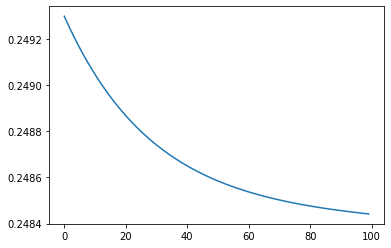

In [343]:
# Grafica
plt.plot(np.arange(epochs), MSE)
plt.show()